In [95]:
# Load all required libraries
suppressMessages({
  library(tidyverse)
  library(ggplot2)
  library(car)           # For VIF
  library(corrplot)      # For correlation plots
  library(mediation)     # For mediation analysis
  library(glmnet)        # For Lasso regression
  library(patchwork)     # For combining plots
  library(RColorBrewer)
  library(sjPlot)
})

In [96]:
# Load data
df_responses <- read.csv("..data/hallucinations.csv")

# Check data structure
cat("Dataset dimensions:", dim(df_responses), "\n")
cat("Available columns:\n")
print(names(df_responses))

Dataset dimensions: 4057 34 
Available columns:
 [1] "id"                        "gender"                   
 [3] "age"                       "visual_vividness"         
 [5] "view_duration"             "lights"                   
 [7] "computer"                  "emotion"                  
 [9] "hallucination_categorical" "hallucination_description"
[11] "emerge_time"               "hallucination_frequency"  
[13] "hallucination_intensity"   "hallucination_duration"   
[15] "consciousness_change"      "consciousness_description"
[17] "hallucination_location"    "percent_missing"          
[19] "auditory_strength"         "gustatory_strength"       
[21] "haptic_strength"           "interoceptive_strength"   
[23] "olfactory_strength"        "visual_strength"          
[25] "foot_strength"             "hand_strength"            
[27] "head_strength"             "mouth_strength"           
[29] "torso_strength"            "perceptual_strength"      
[31] "action_strength"           "sen

**Consciousness analysis**

In [97]:
# Create binary indicators for each consciousness change state
df_responses$dreamlike_state <- grepl("As if in a dreamlike state", df_responses$consciousness_change, ignore.case = TRUE) * 1
df_responses$lost_space <- grepl("Lost a sense of space", df_responses$consciousness_change, ignore.case = TRUE) * 1
df_responses$lost_time <- grepl("Lost a sense of time", df_responses$consciousness_change, ignore.case = TRUE) * 1
df_responses$relaxed_sleepy <- grepl("Became relaxed or sleepy", df_responses$consciousness_change, ignore.case = TRUE) * 1
df_responses$transported_to_another_place <- grepl("Felt transported to another place", df_responses$consciousness_change, ignore.case = TRUE) * 1
df_responses$no_change <- grepl("No change, fully alert in the here and now", df_responses$consciousness_change, ignore.case = TRUE) * 1

# Create an "other" column: 1 if consciousness_change is not NA and none of the known patterns matched
df_responses$other <- ifelse(
  !is.na(df_responses$consciousness_change) &
  rowSums(df_responses[, c("dreamlike_state", "lost_space", "lost_time", "relaxed_sleepy", 
                           "transported_to_another_place", "no_change")]) == 0,
  1, 0
)


In [98]:
# Check if the above code worked properly
df_responses[df_responses$id == 1000, c("consciousness_change",
                                     "dreamlike_state",
                                     "lost_space",
                                     "lost_time",
                                     "relaxed_sleepy",
                                     "transported_to_another_place",
                                     "no_change",
                                     "other")]


,consciousness_change,dreamlike_state,lost_space,lost_time,relaxed_sleepy,transported_to_another_place,no_change,other
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
908,"No change, fully alert in the here and now",0,0,0,0,0,1,0


In [131]:
# Run multiple linear regression
model_consciousness <- lm(visual_vividness ~ transported_to_another_place + dreamlike_state + lost_space + lost_time +
              relaxed_sleepy + no_change,
            data = df_responses)

# Summary of the model
summary(model_consciousness)



Call:
lm(formula = visual_vividness ~ transported_to_another_place + 
    dreamlike_state + lost_space + lost_time + relaxed_sleepy + 
    no_change, data = df_responses)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.5547 -2.8406  0.2339  2.5943  5.6697 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   4.85467    0.11225  43.247  < 2e-16 ***
transported_to_another_place  1.22360    0.18074   6.770 1.47e-11 ***
dreamlike_state               0.91139    0.12735   7.156 9.79e-13 ***
lost_space                    0.46625    0.17405   2.679  0.00742 ** 
lost_time                     0.09881    0.13829   0.715  0.47494    
relaxed_sleepy                0.07453    0.12098   0.616  0.53790    
no_change                    -0.52433    0.13019  -4.027 5.74e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.025 on 4050 degrees of freedom
Multiple R-squared:  0.06905,	Adj

Overall Model Fit:
Adjusted R² = 0.0675 → Consciousness changes explain ~6.8% of the variance in vividness.

This is meaningful, especially for psychological data where small R² values are typical.

Interpretation Summary:
Participants who reported transportation to another place, dreamlike states, or loss of spatial awareness tended to have higher visual imagery vividness. Reporting no change in consciousness was associated with lower vividness. Other shifts (e.g., lost time, sleepy, or "other") were not predictive.

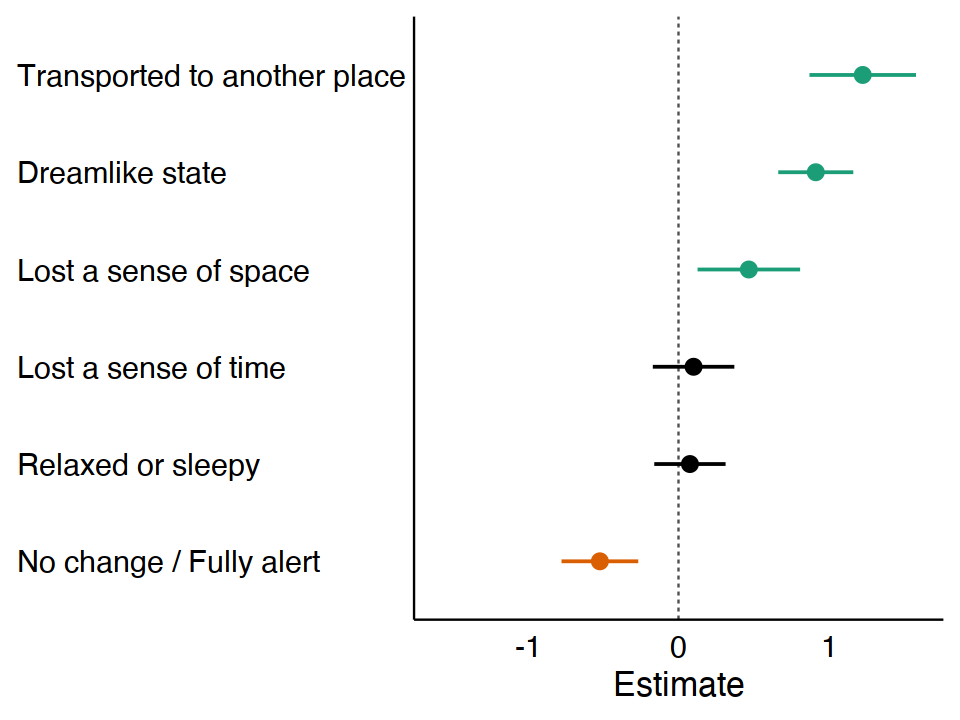

In [160]:
library(broom)

options(repr.plot.width = 8, repr.plot.height = 6)

# Tidy model output and define significance and color
model_df <- tidy(model_consciousness) %>%
  filter(term != "(Intercept)") %>%
  mutate(
    label = c("Transported to another place", "Dreamlike state", "Lost a sense of space",
              "Lost a sense of time",
              "Relaxed or sleepy",
              "No change / Fully alert"),
    significance = case_when(
      p.value < 0.05 & estimate > 0 ~ "pos",
      p.value < 0.05 & estimate < 0 ~ "neg",
      TRUE ~ "ns"
    ),
    color = case_when(
      significance == "pos" ~ "#1b9e77",  # Teal
      significance == "neg" ~ "#d95f02",  # Red
      TRUE ~ "black"
    )
  )

# Reorder for plot
model_df$label <- factor(model_df$label, levels = rev(model_df$label))

# Plot
ggplot(model_df, aes(x = estimate, y = label)) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "gray30") +
  geom_point(aes(color = color), size = 4) +
  geom_errorbarh(aes(xmin = estimate - 1.96 * std.error,
                     xmax = estimate + 1.96 * std.error,
                     color = color),
                 height = 0, linewidth = 0.8) +
  scale_color_identity() +  # Use the colors directly
  xlim(-1.6, 1.6) +
  theme_minimal(base_size = 20) +
  theme(
    text = element_text(family = "Helvetica"),
    panel.grid = element_blank(),
    axis.text.y = element_text(size = 18, angle = 0, hjust = 0, color="black"),
    axis.text.x = element_text(size = 18, color="black"),
    axis.title = element_text(size = 20),
    axis.line.x = element_line(color = "black", linewidth = 0.5),
    axis.line.y = element_line(color = "black", linewidth = 0.5),
    plot.title = element_blank()
  ) +
  xlab("Estimate") +
  ylab(NULL)

**Emotion analysis**

In [147]:
library(dplyr)

df_responses <- df_responses %>%
  mutate(
    emotion_factor = case_when(
      grepl("Unpleasant, wanted it to stop", emotion, ignore.case = TRUE) ~ "unpleasant",
      grepl("Somewhat enjoyable, but easy to stop", emotion, ignore.case = TRUE) ~ "somewhat_enjoyable",
      grepl("Somewhat unpleasant, but didn't mind going on", emotion, ignore.case = TRUE) ~ "somewhat_unpleasant",
      grepl("No feeling about it one way or the other", emotion, ignore.case = TRUE) ~ "neutral",
      grepl("Enjoyable, didn't want it to stop", emotion, ignore.case = TRUE) |
        grepl("Enjoyable, didn't wait it to stop", emotion, ignore.case = TRUE) ~ "enjoyable",
      TRUE ~ NA_character_
    ),
    emotion_factor = factor(emotion_factor,
                            levels = c("unpleasant", "somewhat_unpleasant", "neutral",
                                       "somewhat_enjoyable", "enjoyable"))
  )


In [148]:
df_responses$emotion_factor <- relevel(df_responses$emotion_factor, ref = "neutral")

In [149]:
model_emotion <- lm(visual_vividness ~ emotion_factor, data = df_responses)
summary(model_emotion)


Call:
lm(formula = visual_vividness ~ emotion_factor, data = df_responses)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.8870 -2.5928  0.4072  2.4140  5.4140 

Coefficients:
                                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        4.592805   0.087238  52.647   <2e-16 ***
emotion_factorunpleasant           0.159285   0.183130   0.870    0.384    
emotion_factorsomewhat_unpleasant -0.006848   0.122974  -0.056    0.956    
emotion_factorsomewhat_enjoyable   1.227980   0.132214   9.288   <2e-16 ***
emotion_factorenjoyable            2.294182   0.198709  11.545   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.051 on 4051 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.05275,	Adjusted R-squared:  0.05182 
F-statistic:  56.4 on 4 and 4051 DF,  p-value: < 2.2e-16


Model Summary
Adjusted R² = 0.052 → Emotion explains about 5.2% of the variance in vividness.

Model is statistically significant overall (F = 56.4, p < 2.2e-16), despite small R² — this is common in psychological data.

Coefficient Interpretation (relative to neutral)
Emotion Category	Coefficient	p-value	Interpretation
Intercept (neutral)	4.59	< .001	Participants who felt neutral had an average vividness of ~4.6.
Unpleasant	+0.16	0.384	Slightly higher vividness, not significant.
Somewhat unpleasant	~0.00	0.956	No difference from neutral.
Somewhat enjoyable	+1.23	< .001	Significantly higher vividness than neutral.
Enjoyable	+2.29	< .001	Strongest increase in vividness relative to neutral.

Interpretation
People who reported positive emotions, especially those who found the experience enjoyable and didn't want it to stop, had much higher visual vividness.

The vividness score increases by over 2 full points in the enjoyable group — a large and meaningful effect.

Negative or unpleasant emotions (even those who didn't want to continue) were not significantly different from the neutral group in vividness.

Takeaway
Enjoyment during Ganzflicker is strongly associated with more vivid visual imagery. This suggests that emotionally positive engagement with the stimulus may facilitate stronger internal visual experiences. Unpleasant or neutral experiences do not predict imagery vividness.


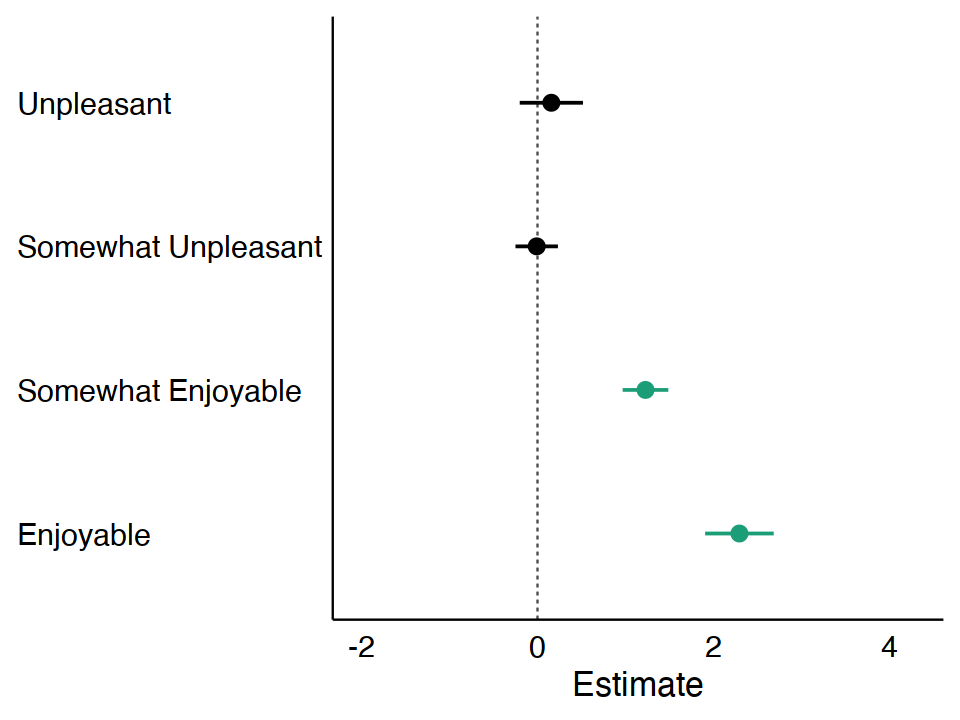

In [159]:
library(broom)
library(dplyr)
library(ggplot2)

options(repr.plot.width = 8, repr.plot.height = 6)

# Tidy the model and manually label coefficients
model_df <- tidy(model_emotion) %>%
  filter(term != "(Intercept)") %>%
  mutate(
    label = dplyr::recode(term,
      "emotion_factorunpleasant" = "Unpleasant",
      "emotion_factorsomewhat_unpleasant" = "Somewhat Unpleasant",
      "emotion_factorsomewhat_enjoyable" = "Somewhat Enjoyable",
      "emotion_factorenjoyable" = "Enjoyable"
    ),
    significance = case_when(
      p.value < 0.05 & estimate > 0 ~ "pos",
      p.value < 0.05 & estimate < 0 ~ "neg",
      TRUE ~ "ns"
    ),
    color = case_when(
      significance == "pos" ~ "#1b9e77",  # Green
      significance == "neg" ~ "#d95f02",  # Red
      TRUE ~ "black"
    )
  )

# Order for display
model_df$label <- factor(model_df$label, levels = rev(unique(model_df$label)))

# Plot
ggplot(model_df, aes(x = estimate, y = label)) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "gray30") +
  geom_point(aes(color = color), size = 4) +
  geom_errorbarh(aes(xmin = estimate - 1.96 * std.error,
                     xmax = estimate + 1.96 * std.error,
                     color = color),
                 height = 0, linewidth = 0.8) +
  scale_color_identity() +
  coord_cartesian(xlim = c(min(model_df$estimate - 2), max(model_df$estimate + 2))) +
  theme_minimal(base_size = 20) +
  theme(
    text = element_text(family = "Helvetica"),
    panel.grid = element_blank(),
    axis.text.y = element_text(size = 18, hjust = 0, color = "black"),
    axis.text.x = element_text(size = 18, color = "black"),
    axis.title = element_text(size = 20),
    axis.line.x = element_line(color = "black", linewidth = 0.5),
    axis.line.y = element_line(color = "black", linewidth = 0.5),
    plot.title = element_blank()
  ) +
  xlab("Estimate") +
  ylab(NULL)
